## Load and prepare data

For details about the formalism, see Gilson M, Kouvaris NE, Deco G, Mangin J-F, Poupon C, Lefranc S, Rivière D, Zamora-López G (submitted)
Network analysis of whole-brain fMRI dynamics: A new framework based on dynamic communicability. biorxiv, http://doi.org/10.1101/421883

The basis of dynamic communicability is the Jacobian estimated in MOUEC_estimation.ipynb. An example of teh Jacobian for a subject is shown below, with the blue diagonal indicating negative values that stabilize the MOU dynamics.

In [3]:
import numpy as np
import scipy.linalg as spl
import matplotlib.pyplot as pp
import os


# load Jacobian matrices
n_sub = 22
n_run = 5
N = 66

try:
    J = np.load('model_param/J_mod.npy')
except:
    print('run the notebook MOUEC_estimation first')

mask_diag = np.eye(N,dtype=np.bool)
mask_offdiag = np.logical_not(mask_diag)

# diagonal Jacobian
J0 = np.zeros(J.shape)
J0[:,:,mask_diag] = J.diagonal(axis1=2,axis2=3)


# plot example Jacobian
pp.figure()
pp.axes([0.2,0.25,0.65,0.65])
pp.imshow(J[0,0,:,:],vmin=-0.2,vmax=0.2,cmap='bwr')
pp.colorbar()
pp.xlabel('source ROI')
pp.ylabel('target ROI')

pp.show()


Calculation of dynamic communicability for a time integration up to 50 TRs. The integration time corresponds to the time of the propagation of activity in the network after a perturbation (at a given node or at all nodes homogeneously).

In [5]:
# integration time
T = 50. # duration
dt = 2. # time step
vT = np.arange(0,T+dt*0.5,dt) # discrete simulation steps
nT = vT.size

# calculate dynamic communicability
dyn_comm = np.zeros([n_sub,n_run,nT,N,N]) # dynamic communicability matrix
for i_sub in range(n_sub):
    for i_run in range(n_run):
        renorm_factor = -np.sum(1./J0[i_sub,i_run,:,:].diagonal()) # integral value of the diagonal Jacobian
        for iT in range(nT):
            dyn_comm[i_sub,i_run,iT,:,:] = (spl.expm(J[i_sub,i_run,:,:]*vT[iT]) - spl.expm(J0[i_sub,i_run,:,:]*vT[iT])) / renorm_factor


Example matrices of communicability for a single subject and fMRI session, at three integration times. Initially sparse, the communicability matrix becomes full.

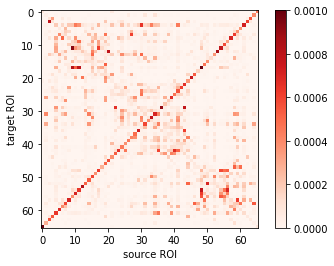

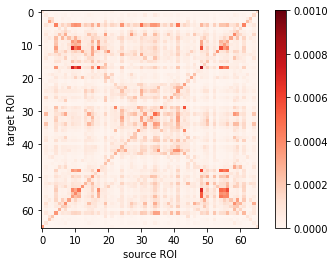

In [6]:
# communicability matrix at 3 integration times
vT2 = [1,4,10]
for iT in vT2:
    pp.figure()
    pp.imshow(dyn_comm[0,0,iT,:,:],vmin=0,vmax=0.001,cmap='Reds')
    pp.colorbar()
    pp.xlabel('source ROI')
    pp.ylabel('target ROI')

pp.show()

Comparison between EC and communicability matrices. Initially aligned with EC, communicability becomes more homogeneous. Note that ROIs without direct connection (EC = 0) can have large communicability for medium and late integration times, indicating the network effect that builds up via indirect paths in the network.

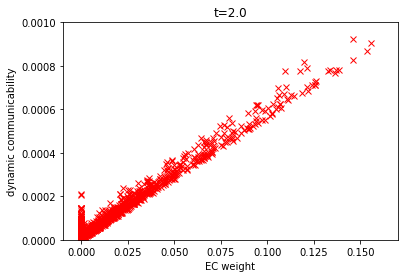

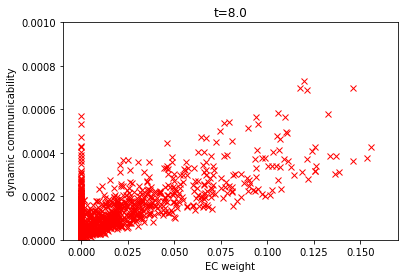

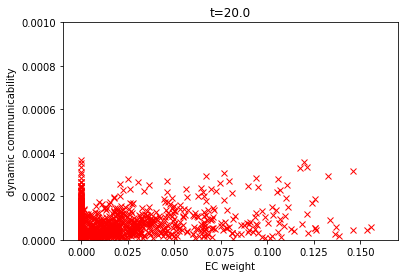

In [7]:
# comparison between communicability and EC matrices over time for a single session
i_sub = 0
i_run = 0

for iT in vT2: # same times as before
    pp.figure()
    pp.plot(J[i_sub,i_run,mask_offdiag],dyn_comm[i_sub,i_run,iT,mask_offdiag],'x',c='r')
    pp.axis(xmin=-0.01,xmax=0.17,ymin=0,ymax=0.001)
    pp.xlabel('EC weight')
    pp.ylabel('dynamic communicability')
    pp.title('t='+str(iT*dt))

## Total communicability and diversity

Total communicability is the sum of all matrix elements of communicability at a given integration time. It results in a time-dependent measure that reflects the global network effect.

Diversity quantifies the heterogeneity between pairs of ROIs. It is defined as a coefficient of variation for the matrix elements. It is also a time-dependent measure, which stabilizes when the integration time increases.

By comparing the two curves, we get quantitative insight about when the network effect is maximal in the brain dynamics and when the activity reaches all ROIs, leading to a homogeneous integration.

In the plots below, black corresponds to rest and red to movie viewing. The error bars indicate the variability over subjects (standard error of the mean).

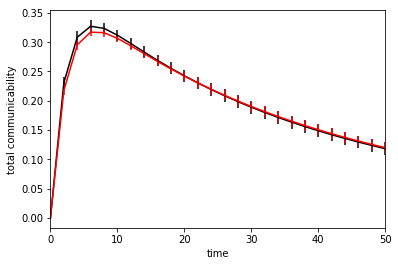

In [8]:
# total communicability
tot_comm = dyn_comm.sum(axis=(3,4))

pp.figure()
pp.errorbar(vT,tot_comm[:,:2,:].mean(axis=(0,1)),yerr=tot_comm[:,:2,:].std(axis=(0,1))/np.sqrt(n_sub),color='k')
pp.errorbar(vT,tot_comm[:,2:,:].mean(axis=(0,1)),yerr=tot_comm[:,2:,:].std(axis=(0,1))/np.sqrt(n_sub),color='r')
pp.axis(xmin=0,xmax=50)
pp.xlabel('time')
pp.ylabel('total communicability')

# diversity
div_comm = dyn_comm[:,:,1:,:,:].std(axis=(3,4)) / dyn_comm[:,:,1:,:,:].mean(axis=(3,4))

pp.figure()
pp.errorbar(vT[1:],div_comm[:,:2,:].mean(axis=(0,1)),yerr=div_comm[:,:2,:].std(axis=(0,1))/np.sqrt(n_sub),color='k')
pp.errorbar(vT[1:],div_comm[:,2:,:].mean(axis=(0,1)),yerr=div_comm[:,2:,:].std(axis=(0,1))/np.sqrt(n_sub),color='r')
pp.axis(xmin=0,xmax=50,ymin=0)
pp.xlabel('time',fontsize=8)
pp.ylabel('communicability\n diversity',fontsize=8)

pp.show()

## Roles for ROIs a described by input and output communicability

The sum of matrix elements over rows gives the input communicability, which measures how each ROI listens to the rest of the network. Likewise, the sum of columns gives the output communicability, which measures their broadcasting influence.

The plots below indicate the changes in input and output communicability for all ROIs (the two hemispheres are lumped together) between rest and movie: red indicates an increase in movie compared to rest, and blue a decrease. Even though the total communicability does not change much, specific ROIs experience strong changes.

In [9]:
# load and reorder ROI labels
ROI_labels = np.load('ROI_labels.npy')
new_ind = np.zeros([N],dtype=np.int)
new_ind[:int(N/2)] = np.arange(int(N/2))
new_ind[int(N/2):] = N - 1 - np.arange(int(N/2))
ROI_labels = ROI_labels[new_ind]


# incoming/outgoing dynamic communicability for each node
# difference movie - rest
dyn_comm_diff = dyn_comm[:,:2,:,:,:].mean(axis=(0,1)) - dyn_comm[:,2:,:,:,:].mean(axis=(0,1))

pp.figure()
pp.imshow(dyn_comm_diff.sum(2).T,vmin=-0.005,vmax=0.005,aspect=1,cmap='bwr')
pp.yticks(range(N),ROI_labels,fontsize=6)
pp.ylabel('node')
pp.title('input communicability')

pp.figure()
pp.imshow(dyn_comm_diff.sum(1).T,vmin=-0.005,vmax=0.005,aspect=1,cmap='bwr')
pp.yticks(range(N),ROI_labels,fontsize=6)
pp.ylabel('node')
pp.title('output communicability')

pp.show()
